# **PLANO DE SAÚDE: ADABOOST**



### Instalação de bibliotecas

In [ ]:
# As bibliotecas utilizadas neste notebook já vêm pré-instaladas no Google Colab

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler         # Balanceamento de classes
from sklearn import ensemble                                   # AdaBoost
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search

### Leitura da base de dados

In [ ]:
dados_plano = pd.read_table("Plano_Saude.txt", sep = "\t")

In [ ]:
# Reordenação de categorias da variável resposta
dados_plano['STATUS'] = pd.Categorical(dados_plano['STATUS'], categories = ['CancInvol', 'CancVol', 'Down', 'Mantem', 'Up'], ordered = True)

### Visualização da base de dados

In [ ]:
display(dados_plano)

,ID_CLIENTE,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,FLAG_MUDANCA_RESIDENCIA_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE,STATUS
0,CLI000001,7.7,0.11,6,4.4,3,0,Nao,0,2,78,Mantem
1,CLI000002,9.8,0.49,3,3.3,1,0,Nao,0,1,21,Mantem
2,CLI000003,6.2,0.12,4,6.4,1,0,Nao,0,0,1,Up
3,CLI000004,7.4,0.35,15,5.6,1,2,Nao,3,0,10,Mantem
4,CLI000005,0.3,0.25,26,3.5,2,2,Nao,0,1,89,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CLI099996,9.4,0.39,10,3.6,1,6,Nao,2,0,26,CancInvol
99996,CLI099997,9.2,0.25,3,6.3,2,0,Nao,1,0,42,Up
99997,CLI099998,9.6,0.09,5,8.0,2,2,Nao,1,0,23,Mantem
99998,CLI099999,5.2,0.43,2,5.9,1,0,Sim,0,0,33,Mantem


### Separação de features e target

In [ ]:
X = dados_plano.drop(columns = ['STATUS', 'ID_CLIENTE'])
y = dados_plano['STATUS']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [ ]:
X = pd.get_dummies(X, drop_first = True)

### Balanceamento de base de dados grande (undersampling)

In [ ]:
# Contagem de valores na variável resposta antes do balanceamento
y.value_counts()

,count
STATUS,
Mantem,67000
Up,13000
Down,10000
CancInvol,6000
CancVol,4000


In [ ]:
# Balanceamento
rus = RandomUnderSampler(random_state = 123)
X_sample, y_sample = rus.fit_resample(X, y)

In [ ]:
# Contagem de valores na variável resposta após o balanceamento
y_sample.value_counts()

,count
STATUS,
CancInvol,4000
CancVol,4000
Down,4000
Mantem,4000
Up,4000


### Modelo 1: AdaBoost com otimização de hiperparâmetros via validação cruzada, com random search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01)
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC-OVR e k = 5 (EXECUÇÃO ONEROSA)
adaboost = ensemble.AdaBoostClassifier(random_state = 123)
cv = KFold(n_splits = 5, shuffle = True, random_state = 123)
scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(adaboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
random_search.fit(X_sample, y_sample, sample_weight = np.ones(len(y_sample)))

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=AdaBoostClassifier(random_state=123), n_iter=100,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC_OVR',
                   scoring={'AUC_OVR': 'roc_auc_ovr',
                            'balanced_accuracy': 'balanced_accuracy'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 30, 'learning_rate': 0.37}


In [ ]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC-OVR médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC_OVR', 'std_test_AUC_OVR', 'rank_test_AUC_OVR',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy']].sort_values(by = 'rank_test_AUC_OVR')
resultados_grid

,params,mean_test_AUC_OVR,std_test_AUC_OVR,rank_test_AUC_OVR,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy
30,"{'n_estimators': 30, 'learning_rate': 0.37}",0.866033,0.003102,1,0.633429,0.006777,73
69,"{'n_estimators': 120, 'learning_rate': 0.09}",0.865996,0.002125,2,0.634833,0.007063,72
70,"{'n_estimators': 60, 'learning_rate': 0.180000...",0.865824,0.002034,3,0.633360,0.006182,74
12,"{'n_estimators': 100, 'learning_rate': 0.11}",0.865773,0.002256,4,0.635127,0.007057,71
71,"{'n_estimators': 30, 'learning_rate': 0.420000...",0.865508,0.003105,5,0.635769,0.007551,70
...,...,...,...,...,...,...,...
17,"{'n_estimators': 10, 'learning_rate': 0.17}",0.808569,0.003356,96,0.518978,0.005283,96
31,"{'n_estimators': 40, 'learning_rate': 0.03}",0.800178,0.003780,97,0.514696,0.008774,97
29,"{'n_estimators': 80, 'learning_rate': 0.01}",0.776312,0.001323,98,0.468895,0.009616,98
89,"{'n_estimators': 60, 'learning_rate': 0.01}",0.752031,0.009962,99,0.407865,0.013272,100


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
adaboost_1 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01)
}

In [ ]:
# Validação cruzada estratificada aninhada com random search e otimização de AUC-OVR, k1 = 2 e k2 = 5 (EXECUÇÃO ONEROSA)
adaboost = ensemble.AdaBoostClassifier(random_state = 123)
inner_cv = KFold(n_splits = 2, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(adaboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
nested_scores = cross_validate(random_search, X = X_sample, y = y_sample, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC_OVR'].round(3))
print("Média de AUC-OVR: " + str(round(np.mean(nested_scores['test_AUC_OVR']), 3)))
print("D.P. de AUC-OVR: " + str(round(np.std(nested_scores['test_AUC_OVR']), 3)))

[0.865 0.861 0.873 0.865 0.866]
Média de AUC-OVR: 0.866
D.P. de AUC-OVR: 0.004


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.624 0.628 0.652 0.631 0.636]
Média de Acurácia Balanceada: 0.634
D.P. de Acurácia Balanceada: 0.01


### Aplicação do modelo final de AdaBoost na base de dados



In [ ]:
# Atribuição das probabilidades preditas por categoria
adaboost_1.fit(X, y)
y_prob = pd.DataFrame(adaboost_1.predict_proba(X)[:,:], columns = adaboost_1.classes_)
dados_plano = pd.concat([dados_plano, y_prob], axis = 1)

In [ ]:
# Atribuição da categoria predita
dados_plano['y_pred'] = adaboost_1.predict(X)

In [ ]:
# Matriz de classificação absoluta: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'])

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,1969,145,77,3809,0
CancVol,283,769,232,2716,0
Down,103,151,1266,8480,0
Mantem,250,53,268,66311,118
Up,6,0,2,12228,764


In [ ]:
# Matriz de classificação relativa: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'], normalize = 'index').round(2)

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,0.33,0.02,0.01,0.63,0.00
CancVol,0.07,0.19,0.06,0.68,0.00
Down,0.01,0.02,0.13,0.85,0.00
Mantem,0.00,0.00,0.00,0.99,0.00
Up,0.00,0.00,0.00,0.94,0.06


### Importância das features do modelo final

In [ ]:
# Cálculo de medida de importância de Gini
importancias = adaboost_1.feature_importances_
features = X.columns

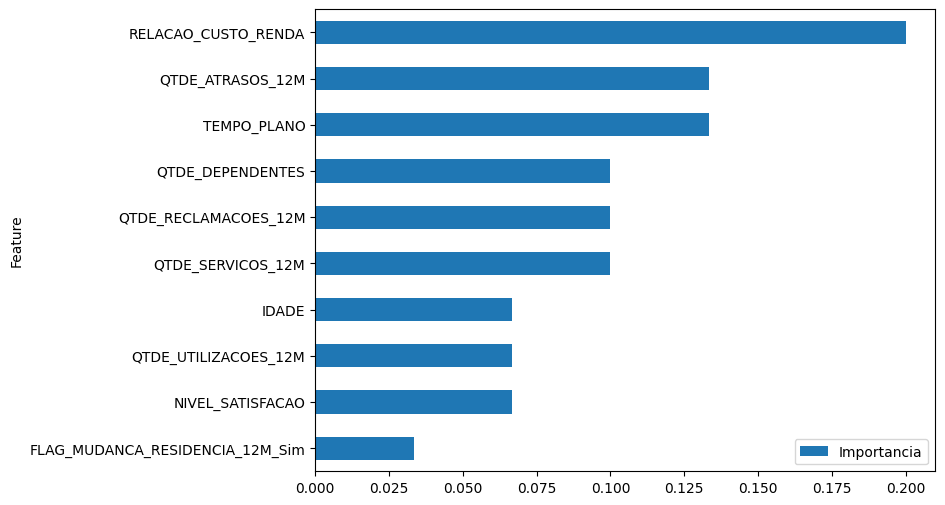

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações: NÃO IMPLEMENTADO PARA ADABOOST NA BIBLIOTECA 'SHAP' NO CASO MULTINOMIAL, APENAS BINÁRIO